# Assignment 5

This assignment has weighting $1.5$.

Author: Nian Xiaodong (3035087112)

# Model tuning and evaluation

In [1]:
# Added version check for recent scikit-learn 0.18 checks
from distutils.version import LooseVersion as Version
from sklearn import __version__ as sklearn_version

## Dataset

We will use the Wisconsin breast cancer dataset for the following questions

In [2]:
import pandas as pd

wdbc_source = 'https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data'
#wdbc_source = '../datasets/wdbc/wdbc.data'

df = pd.read_csv(wdbc_source, header=None)

In [3]:
from sklearn.preprocessing import LabelEncoder
X = df.loc[:, 2:].values
y = df.loc[:, 1].values
le = LabelEncoder()
y = le.fit_transform(y)
le.transform(['M', 'B'])

array([1, 0], dtype=int64)

In [4]:
if Version(sklearn_version) < '0.18':
    from sklearn.cross_validation import train_test_split
else:
    from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.20, random_state=1)

In [5]:
%matplotlib inline

# K-fold validation (20 points)

Someone wrote the code below to conduct cross validation.
Do you see anything wrong with it?
And if so, correct the code and provide an explanation.

In [6]:
import numpy as np
import copy
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import Perceptron
from sklearn.pipeline import Pipeline

if Version(sklearn_version) < '0.18':
    from sklearn.cross_validation import StratifiedKFold
else:
    from sklearn.model_selection import StratifiedKFold

scl = StandardScaler()
pca = PCA(n_components=2)
clf = Perceptron(random_state=1)

# data preprocessing
X_train_std = scl.fit_transform(X_train)
X_test_std = scl.transform(X_test)

X_train_pca = pca.fit_transform(X_train_std)
X_test_pca = pca.transform(X_test_std)

# compute the data indices for each fold
if Version(sklearn_version) < '0.18':
    kfold = StratifiedKFold(y=y_train, 
                            n_folds=10,
                            random_state=1)
else:
    kfold = StratifiedKFold(n_splits=10,
                            random_state=1).split(X_train, y_train)

num_epochs = 2
scores = []

enumerate_kfold = list(enumerate(kfold))
for epoch in range(num_epochs):
    for k, (train, test) in enumerate_kfold:
        clf.fit(X_train_std[train], y_train[train])
        score = clf.score(X_train_std[test], y_train[test])
        scores.append(score)
        print('Epoch: %s, Fold: %s, Class dist.: %s, Acc: %.3f' % (epoch,
                                                                   k, 
                                                                   np.bincount(y_train[train]),
                                                                   score))
    print('')
    
print('\nCV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

Epoch: 0, Fold: 0, Class dist.: [256 153], Acc: 0.913
Epoch: 0, Fold: 1, Class dist.: [256 153], Acc: 0.978
Epoch: 0, Fold: 2, Class dist.: [256 153], Acc: 0.935
Epoch: 0, Fold: 3, Class dist.: [256 153], Acc: 0.935
Epoch: 0, Fold: 4, Class dist.: [256 153], Acc: 0.957
Epoch: 0, Fold: 5, Class dist.: [257 153], Acc: 1.000
Epoch: 0, Fold: 6, Class dist.: [257 153], Acc: 0.933
Epoch: 0, Fold: 7, Class dist.: [257 153], Acc: 0.978
Epoch: 0, Fold: 8, Class dist.: [257 153], Acc: 0.978
Epoch: 0, Fold: 9, Class dist.: [257 153], Acc: 0.978

Epoch: 1, Fold: 0, Class dist.: [256 153], Acc: 0.913
Epoch: 1, Fold: 1, Class dist.: [256 153], Acc: 0.978
Epoch: 1, Fold: 2, Class dist.: [256 153], Acc: 0.935
Epoch: 1, Fold: 3, Class dist.: [256 153], Acc: 0.935
Epoch: 1, Fold: 4, Class dist.: [256 153], Acc: 0.957
Epoch: 1, Fold: 5, Class dist.: [257 153], Acc: 1.000
Epoch: 1, Fold: 6, Class dist.: [257 153], Acc: 0.933
Epoch: 1, Fold: 7, Class dist.: [257 153], Acc: 0.978
Epoch: 1, Fold: 8, Class di

## Answer

By changing

    clf.partial_fit(X_train_std[train], y_train[train], classes=np.unique(y_train))
    
to

    clf.fit(X_train_std[train], y_train[train])
    
We could avoid cumulative learning, because the iterations of K-fold should be independent. Partial fit will not initialize the weight each time we train and could result in cumulative learning, which is not independent.

# Precision-recall curve (40 points)

We have plotted ROC (receiver operator characteristics) curve for the breast cancer dataset.

Plot the precision-recall curve for the same data set using the same experimental setup.
What similarities and differences you can find between ROC and precision-recall curves?

You can find more information about precision-recall curve online such as: http://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_curve.html

# Answer

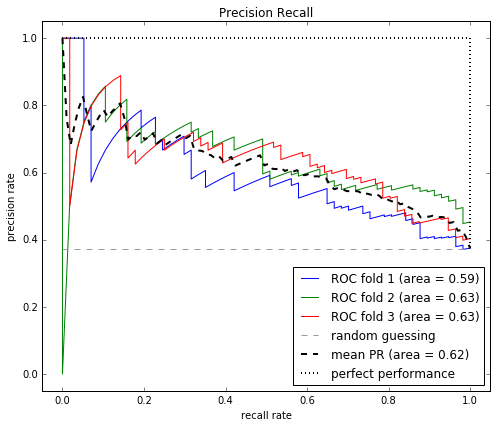

In [7]:
# your code
%matplotlib inline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import precision_recall_curve, auc
from scipy import interp
import matplotlib.pyplot as plt

pipe_lr = Pipeline([('scl', StandardScaler()),
                    ('pca', PCA(n_components=2)),
                    ('clf', LogisticRegression(penalty='l2', 
                                               random_state=0, 
                                               C=100.0))])

# intentionally use only 2 features to make the task harder and the curves more interesting
X_train2 = X_train[:, [4, 14]]
X_test2 = X_test[:, [4, 14]]


if Version(sklearn_version) < '0.18':
    cv = StratifiedKFold(y_train, 
                         n_folds=3, 
                         random_state=1)
    
else:
    cv = list(StratifiedKFold(n_splits=3, 
                              random_state=1).split(X_train, y_train))

fig = plt.figure(figsize=(7, 6))

mean_precision = 0.0
mean_recall = np.linspace(0, 1, 100)

for i, (train, test) in enumerate(cv):
    probas = pipe_lr.fit(X_train2[train],
                         y_train[train]).predict_proba(X_train2[test])

    precision, recall, _ = precision_recall_curve(y_train[test],
                                       probas[:, 1])
    
    mean_precision += interp(mean_recall, recall[::-1], precision[::-1])
    pr_auc = auc(recall, precision)
    plt.plot(recall,
             precision,
             lw=1,
             label='ROC fold %d (area = %0.2f)'
                   % (i+1, pr_auc))

positive_ratio = np.count_nonzero(y_train)/len(y_train)
plt.plot([0, 1],
         [positive_ratio, positive_ratio],
         linestyle='--',
         color=(0.6, 0.6, 0.6),
         label='random guessing')

mean_precision /= len(cv)
mean_precision[0] = 1
mean_precision[-1] = positive_ratio
mean_auc = auc(mean_recall, mean_precision)
plt.plot(mean_recall, mean_precision, 'k--',
         label='mean PR (area = %0.2f)' % mean_auc, lw=2)
plt.plot([0, 1, 1],
         [1, 1, positive_ratio],
         lw=2,
         linestyle=':',
         color='black',
         label='perfect performance')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('recall rate')
plt.ylabel('precision rate')
plt.title('Precision Recall')
plt.legend(loc="lower right")

plt.tight_layout()
# plt.savefig('./figures/pr.png', dpi=300)
plt.show()

### Similarities

1. Better if the AUC is larger;
2. Mainly focus on positive predict result, and use TP/P (true positive ratio or recall ratio) as a factor;
3. The evaluation results of the 2 methods are simlar;

### Differences

1. ROC curve begin at lower left corner and end at upper right corner, PR curve begin at upper left corner and end at lower right;
2. ROC curve is better if near to upper left corner, PR curve is better if near to upper right corner;
3. The random guessing curve is shaped like "╱" in ROC space, and shaped like "─" (at postive ratio of training set) in PR space;
3. The perfect performance curve is shaped like "┌" in ROC space, and shaped like "┐" in PR space;
4. The evaluation result of PR curve depends more on positive ratio of the seleted training set.

# Ensemble learning

We have used the following code to compute and plot the ensemble error from individual classifiers for binary classification:

In [8]:
from scipy.misc import comb
import math
import numpy as np

def ensemble_error(num_classifier, base_error):
    k_start = math.ceil(num_classifier/2)
    probs = [comb(num_classifier, k)*(base_error**k)*((1-base_error)**(num_classifier-k)) for k in range(k_start, num_classifier+1)]
    return sum(probs)

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

In [10]:
def plot_base_error(ensemble_error_func, num_classifier, error_delta):

    error_range = np.arange(0.0, 1+error_delta, error_delta)
    ensemble_errors = [ensemble_error_func(num_classifier=num_classifier, base_error=error) for error in error_range]

    plt.plot(error_range, ensemble_errors, 
             label = 'ensemble error',
             linewidth=2)
    plt.plot(error_range, error_range,
             label = 'base error',
             linestyle = '--',
             linewidth=2)
    plt.xlabel('base error')
    plt.ylabel('base/ensemble error')
    plt.legend(loc='best')
    plt.grid()
    plt.show()

In [11]:
num_classifier = 11
error_delta = 0.01
base_error = 0.25

In [12]:

print(ensemble_error(num_classifier=num_classifier, base_error=base_error))


0.034327507019


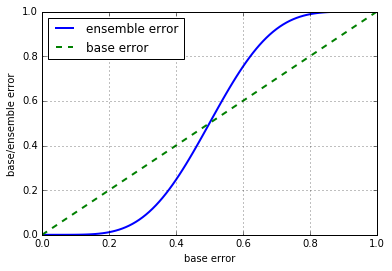

In [13]:
plot_base_error(ensemble_error, num_classifier=num_classifier, error_delta=error_delta)

# Number of classifiers (40 points)

The function plot_base_error() above plots the ensemble error as a function of the base error given a fixed number of classifiers.

Write another function to plot ensembe error versus different number of classifiers with a given base error.

Does the ensemble error always go down with more classifiers? 
Why or why not?

Can you improve the method ensemble_error() to produce a more reasonable plot?

## Answer

The code for plotting is below:

In [14]:
def plot_num_classifier(ensemble_error_func, max_num_classifier, base_error):
    
    num_range = range(1, max_num_classifier+1)

    ensemble_errors = [ensemble_error_func(num_classifier=num_classifier, base_error=base_error) 
                       for num_classifier in num_range]

    plt.plot(num_range, ensemble_errors, 
             label = 'ensemble error',
             linewidth=2)
    
    plt.xlabel('number of classifier')
    plt.ylabel('ensemble error')
    plt.legend(loc='best')
    plt.grid()
    plt.show()

State your observations of the experiments of your code:

* The overall trend goes down when the number of classifiers increases.
* However, the curve is showed as in oscillation, when the number of classifiers increases to be an even number, the ensemble error would increase suddenly instead of decrease, and the ensemble error could be even larger than base error when number of classifier is small. 

In [15]:
max_num_classifiers = 20
base_error = 0.25

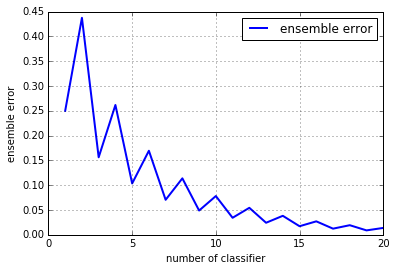

In [16]:
plot_num_classifier(ensemble_error, 
                    max_num_classifier=max_num_classifiers, 
                    base_error=base_error)

Explain your observations above.

* When there are more classifiers, the probability of that at least more than N/2 classifiers predict wrongly could be smaller, thus, the overall trend goes down when the number of classifiers increases.
* However, when the number of classifiers increases from an odd number to be an even number, ceil(num_classifier/2) remains unchanged, but at the time the number of situation of wrong prediciton has increased by 1 while correct situation prediction remains the same amount. As a result, the ensemble error increased at such situation.

Describe a better algorithm for computing the ensemble error.

* Noticed that when number of classifiers is an even number, the error probability at N/2 is half by half, and to improve the algorithm and try to make the result more reasonable, I divided it by 2 at N/2 to make it remain the same as before. As a result, the curve keeps decreasing when the number of classifiers increases.

In [17]:
def better_ensemble_error(num_classifier, base_error):
    # replace the following default line with your implementation of a better algorithm for ensemble error
    k_start = math.ceil(num_classifier/2)
    probs = [comb(num_classifier, k)*(base_error**k)*((1-base_error)**(num_classifier-k)) 
             for k in range(k_start, num_classifier+1)]
    if (num_classifier%2) == 0:
        probs[0] /= 2
    return sum(probs)

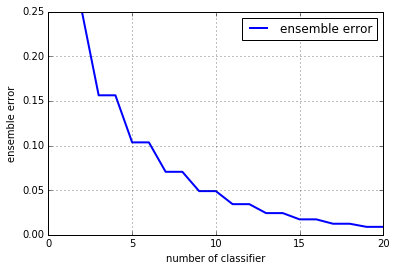

In [18]:
plot_num_classifier(better_ensemble_error, 
                    max_num_classifier=max_num_classifiers, 
                    base_error=base_error)

<br><br><center> - END - </center>